In [1]:
# Polars vs Pandas Performance Benchmark
# Complete benchmark suite for comparing Polars and Pandas performance

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import timeit
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Set plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

In [4]:
class MemoryMonitor:
    """Context manager to monitor memory usage"""

    def __init__(self):
        self.process = psutil.Process()

    def __enter__(self):
        gc.collect()  # Clean up before measurement
        self.start_memory = self.process.memory_info().rss / 1024 / 1024  # MB
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end_memory = self.process.memory_info().rss / 1024 / 1024  # MB
        self.peak_memory = self.process.memory_info().rss / 1024 / 1024  # MB

    def get_memory_usage(self):
        return self.peak_memory - self.start_memory

In [5]:
def generate_large_dataset(filename="large_dataset.csv", num_rows=1_000_000):
    """Generate a large CSV dataset for benchmarking"""
    print(f"Generating dataset with {num_rows:,} rows...")

    np.random.seed(42)

    data = {
        "id": range(num_rows),
        "category": np.random.choice(["A", "B", "C", "D", "E"], num_rows),
        "subcategory": np.random.choice(["X", "Y", "Z"], num_rows),
        "value1": np.random.normal(100, 15, num_rows),
        "value2": np.random.exponential(50, num_rows),
        "value3": np.random.uniform(0, 1000, num_rows),
        "date": pd.date_range("2020-01-01", periods=num_rows, freq="1min"),
        "flag": np.random.choice([True, False], num_rows),
        "text_data": [f"text_{i%1000}" for i in range(num_rows)],
    }

    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")
    return filename

In [6]:
def benchmark_loading(filename):
    """Benchmark CSV loading performance"""
    print("\n" + "=" * 50)
    print("BENCHMARKING CSV LOADING")
    print("=" * 50)

    results = {}

    # Pandas loading
    print("Testing Pandas loading...")
    with MemoryMonitor() as monitor:
        start_time = timeit.default_timer()
        df_pandas = pd.read_csv(filename)
        pandas_load_time = timeit.default_timer() - start_time
    pandas_load_memory = monitor.get_memory_usage()

    # Polars loading
    print("Testing Polars loading...")
    with MemoryMonitor() as monitor:
        start_time = timeit.default_timer()
        df_polars = pl.read_csv(filename)
        polars_load_time = timeit.default_timer() - start_time
    polars_load_memory = monitor.get_memory_usage()

    results["loading"] = {
        "pandas_time": pandas_load_time,
        "polars_time": polars_load_time,
        "pandas_memory": pandas_load_memory,
        "polars_memory": polars_load_memory,
        "speedup": pandas_load_time / polars_load_time,
    }

    print(f"Pandas loading time: {pandas_load_time:.3f}s")
    print(f"Polars loading time: {polars_load_time:.3f}s")
    print(f"Speedup: {results['loading']['speedup']:.2f}x")

    return df_pandas, df_polars, results

In [7]:
def benchmark_filtering(df_pandas, df_polars):
    """Benchmark filtering operations"""
    print("\n" + "=" * 50)
    print("BENCHMARKING FILTERING")
    print("=" * 50)

    results = {}

    # Complex filter: category in ['A', 'B'] AND value1 > 100 AND flag == True
    print("Testing complex filtering...")

    # Pandas filtering
    def pandas_filter():
        return df_pandas[
            (df_pandas["category"].isin(["A", "B"]))
            & (df_pandas["value1"] > 100)
            & (df_pandas["flag"] == True)
        ]

    with MemoryMonitor() as monitor:
        pandas_time = timeit.timeit(pandas_filter, number=5) / 5
    pandas_memory = monitor.get_memory_usage()

    # Polars filtering
    def polars_filter():
        return df_polars.filter(
            (pl.col("category").is_in(["A", "B"]))
            & (pl.col("value1") > 100)
            & (pl.col("flag"))
        )

    with MemoryMonitor() as monitor:
        polars_time = timeit.timeit(polars_filter, number=5) / 5
    polars_memory = monitor.get_memory_usage()

    results["filtering"] = {
        "pandas_time": pandas_time,
        "polars_time": polars_time,
        "pandas_memory": pandas_memory,
        "polars_memory": polars_memory,
        "speedup": pandas_time / polars_time,
    }

    print(f"Pandas filtering time: {pandas_time:.3f}s")
    print(f"Polars filtering time: {polars_time:.3f}s")
    print(f"Speedup: {results['filtering']['speedup']:.2f}x")

    return results

In [8]:
def benchmark_groupby_agg(df_pandas, df_polars):
    """Benchmark groupby and aggregation operations"""
    print("\n" + "=" * 50)
    print("BENCHMARKING GROUPBY & AGGREGATION")
    print("=" * 50)

    results = {}

    print("Testing groupby aggregation...")

    # Pandas groupby
    def pandas_groupby():
        return df_pandas.groupby(["category", "subcategory"]).agg(
            {
                "value1": ["mean", "std", "count"],
                "value2": ["sum", "max", "min"],
                "value3": ["median", "var"],
            }
        )

    with MemoryMonitor() as monitor:
        pandas_time = timeit.timeit(pandas_groupby, number=3) / 3
    pandas_memory = monitor.get_memory_usage()

    # Polars groupby
    def polars_groupby():
        return df_polars.group_by(["category", "subcategory"]).agg(
            [
                pl.col("value1").mean().alias("value1_mean"),
                pl.col("value1").std().alias("value1_std"),
                pl.col("value1").count().alias("value1_count"),
                pl.col("value2").sum().alias("value2_sum"),
                pl.col("value2").max().alias("value2_max"),
                pl.col("value2").min().alias("value2_min"),
                pl.col("value3").median().alias("value3_median"),
                pl.col("value3").var().alias("value3_var"),
            ]
        )

    with MemoryMonitor() as monitor:
        polars_time = timeit.timeit(polars_groupby, number=3) / 3
    polars_memory = monitor.get_memory_usage()

    results["groupby"] = {
        "pandas_time": pandas_time,
        "polars_time": polars_time,
        "pandas_memory": pandas_memory,
        "polars_memory": polars_memory,
        "speedup": pandas_time / polars_time,
    }

    print(f"Pandas groupby time: {pandas_time:.3f}s")
    print(f"Polars groupby time: {polars_time:.3f}s")
    print(f"Speedup: {results['groupby']['speedup']:.2f}x")

    return results

In [9]:
def benchmark_string_operations(df_pandas, df_polars):
    """Benchmark string operations"""
    print("\n" + "=" * 50)
    print("BENCHMARKING STRING OPERATIONS")
    print("=" * 50)

    results = {}

    print("Testing string operations...")

    # Pandas string operations
    def pandas_string_ops():
        return df_pandas["text_data"].str.contains("text_1").sum()

    with MemoryMonitor() as monitor:
        pandas_time = timeit.timeit(pandas_string_ops, number=5) / 5
    pandas_memory = monitor.get_memory_usage()

    # Polars string operations
    def polars_string_ops():
        return df_polars.select(pl.col("text_data").str.contains("text_1").sum()).item()

    with MemoryMonitor() as monitor:
        polars_time = timeit.timeit(polars_string_ops, number=5) / 5
    polars_memory = monitor.get_memory_usage()

    results["string_ops"] = {
        "pandas_time": pandas_time,
        "polars_time": polars_time,
        "pandas_memory": pandas_memory,
        "polars_memory": polars_memory,
        "speedup": pandas_time / polars_time,
    }

    print(f"Pandas string ops time: {pandas_time:.3f}s")
    print(f"Polars string ops time: {polars_time:.3f}s")
    print(f"Speedup: {results['string_ops']['speedup']:.2f}x")

    return results

In [10]:
def benchmark_sorting(df_pandas, df_polars):
    """Benchmark sorting operations"""
    print("\n" + "=" * 50)
    print("BENCHMARKING SORTING")
    print("=" * 50)

    results = {}

    print("Testing multi-column sorting...")

    # Pandas sorting
    def pandas_sort():
        return df_pandas.sort_values(["category", "value1"], ascending=[True, False])

    with MemoryMonitor() as monitor:
        pandas_time = timeit.timeit(pandas_sort, number=3) / 3
    pandas_memory = monitor.get_memory_usage()

    # Polars sorting
    def polars_sort():
        return df_polars.sort(["category", "value1"], descending=[False, True])

    with MemoryMonitor() as monitor:
        polars_time = timeit.timeit(polars_sort, number=3) / 3
    polars_memory = monitor.get_memory_usage()

    results["sorting"] = {
        "pandas_time": pandas_time,
        "polars_time": polars_time,
        "pandas_memory": pandas_memory,
        "polars_memory": polars_memory,
        "speedup": pandas_time / polars_time,
    }

    print(f"Pandas sorting time: {pandas_time:.3f}s")
    print(f"Polars sorting time: {polars_time:.3f}s")
    print(f"Speedup: {results['sorting']['speedup']:.2f}x")

    return results

In [11]:
def visualize_results(all_results):
    """Create comprehensive visualization of benchmark results"""
    print("\n" + "=" * 50)
    print("CREATING VISUALIZATIONS")
    print("=" * 50)

    # Prepare data for plotting
    operations = list(all_results.keys())
    speedups = [all_results[op]["speedup"] for op in operations]
    pandas_times = [all_results[op]["pandas_time"] for op in operations]
    polars_times = [all_results[op]["polars_time"] for op in operations]
    pandas_memory = [all_results[op]["pandas_memory"] for op in operations]
    polars_memory = [all_results[op]["polars_memory"] for op in operations]

    # Create subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(
        "Polars vs Pandas Performance Benchmark", fontsize=16, fontweight="bold"
    )

    # 1. Speedup comparison
    ax1 = axes[0, 0]
    bars = ax1.bar(
        operations,
        speedups,
        color=["#FF6B6B", "#4ECDC4", "#45B7D1", "#96CEB4", "#FFEAA7"],
    )
    ax1.set_title("Speed Improvement (Higher = Better)", fontweight="bold")
    ax1.set_ylabel("Speedup Factor (x times faster)")
    ax1.tick_params(axis="x", rotation=45)
    ax1.axhline(y=1, color="red", linestyle="--", alpha=0.7, label="No improvement")
    ax1.legend()

    # Add value labels on bars
    for bar, speedup in zip(bars, speedups):
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.1,
            f"{speedup:.1f}x",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # 2. Execution time comparison
    ax2 = axes[0, 1]
    x = np.arange(len(operations))
    width = 0.35

    bars1 = ax2.bar(x - width / 2, pandas_times, width, label="Pandas", color="#FF6B6B", alpha=0.8)
    bars2 = ax2.bar(x + width / 2, polars_times, width, label="Polars", color="#4ECDC4", alpha=0.8)

    ax2.set_title("Execution Time Comparison", fontweight="bold")
    ax2.set_ylabel("Time (seconds)")
    ax2.set_xlabel("Operations")
    ax2.set_xticks(x)
    ax2.set_xticklabels(operations, rotation=45)
    ax2.legend()
    ax2.set_yscale("log")  # Log scale for better visibility

    # Add value labels on time bars
    for bar, time in zip(bars1, pandas_times):
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width() / 2.0,
            height * 1.1,
            f"{time:.3f}s",
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=45
        )
    
    for bar, time in zip(bars2, polars_times):
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width() / 2.0,
            height * 1.1,
            f"{time:.3f}s",
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=45
        )

    # 3. Memory usage comparison
    ax3 = axes[1, 0]
    x = np.arange(len(operations))

    bars1 = ax3.bar(x - width / 2, pandas_memory, width, label="Pandas", color="#FF6B6B", alpha=0.8)
    bars2 = ax3.bar(x + width / 2, polars_memory, width, label="Polars", color="#4ECDC4", alpha=0.8)

    ax3.set_title("Memory Usage Comparison", fontweight="bold")
    ax3.set_ylabel("Memory (MB)")
    ax3.set_xlabel("Operations")
    ax3.set_xticks(x)
    ax3.set_xticklabels(operations, rotation=45)
    ax3.legend()

    # Add value labels on memory bars
    for bar, memory in zip(bars1, pandas_memory):
        height = bar.get_height()
        ax3.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + max(pandas_memory) * 0.02,
            f"{memory:.1f}MB",
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=45
        )
    
    for bar, memory in zip(bars2, polars_memory):
        height = bar.get_height()
        ax3.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + max(polars_memory) * 0.02,
            f"{memory:.1f}MB",
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=45
        )

    # 4. Performance summary heatmap
    ax4 = axes[1, 1]

    # Create performance matrix
    perf_data = []
    metrics = [
        "Time (lower=better)",
        "Memory (lower=better)",
        "Speedup (higher=better)",
    ]

    for op in operations:
        # Normalize metrics for heatmap (0-1 scale)
        time_ratio = all_results[op]["polars_time"] / all_results[op]["pandas_time"]
        memory_ratio = (
            all_results[op]["polars_memory"] / all_results[op]["pandas_memory"]
            if all_results[op]["pandas_memory"] > 0
            else 0
        )
        speedup_norm = min(
            all_results[op]["speedup"] / 10, 1
        )  # Cap at 10x for visualization

        perf_data.append([1 - time_ratio, 1 - memory_ratio, speedup_norm])

    im = ax4.imshow(np.array(perf_data).T, cmap="RdYlGn", aspect="auto")
    ax4.set_title("Performance Heatmap\n(Green = Better)", fontweight="bold")
    ax4.set_xticks(range(len(operations)))
    ax4.set_xticklabels(operations, rotation=45)
    ax4.set_yticks(range(len(metrics)))
    ax4.set_yticklabels(metrics)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax4)
    cbar.set_label("Performance Score")

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n" + "=" * 50)
    print("PERFORMANCE SUMMARY")
    print("=" * 50)

    avg_speedup = np.mean(speedups)
    max_speedup = max(speedups)
    max_speedup_op = operations[speedups.index(max_speedup)]

    print(f"Average speedup: {avg_speedup:.2f}x")
    print(f"Maximum speedup: {max_speedup:.2f}x ({max_speedup_op})")

    total_pandas_time = sum(pandas_times)
    total_polars_time = sum(polars_times)
    overall_speedup = total_pandas_time / total_polars_time

    print(f"Overall time - Pandas: {total_pandas_time:.3f}s")
    print(f"Overall time - Polars: {total_polars_time:.3f}s")
    print(f"Overall speedup: {overall_speedup:.2f}x")

In [12]:
def run_complete_benchmark(num_rows=1_000_000):
    """Run the complete benchmark suite"""
    print("POLARS VS PANDAS PERFORMANCE BENCHMARK")
    print("=" * 50)
    print(f"Dataset size: {num_rows:,} rows")

    # Generate dataset
    filename = generate_large_dataset(num_rows=num_rows)

    try:
        # Load data and benchmark loading
        df_pandas, df_polars, results = benchmark_loading(filename)

        # Run all benchmarks
        results.update(benchmark_filtering(df_pandas, df_polars))
        results.update(benchmark_groupby_agg(df_pandas, df_polars))
        results.update(benchmark_string_operations(df_pandas, df_polars))
        results.update(benchmark_sorting(df_pandas, df_polars))

        # Visualize results
        visualize_results(results)

        return results

    finally:
        # Cleanup
        if Path(filename).exists():
            Path(filename).unlink()
            print(f"\nCleaned up {filename}")

POLARS VS PANDAS PERFORMANCE BENCHMARK
Dataset size: 1,000,000 rows
Generating dataset with 1,000,000 rows...
Dataset saved to large_dataset.csv

BENCHMARKING CSV LOADING
Testing Pandas loading...
Testing Polars loading...
Pandas loading time: 1.419s
Polars loading time: 0.324s
Speedup: 4.39x

BENCHMARKING FILTERING
Testing complex filtering...
Pandas filtering time: 0.055s
Polars filtering time: 0.009s
Speedup: 6.22x

BENCHMARKING GROUPBY & AGGREGATION
Testing groupby aggregation...
Pandas groupby time: 0.176s
Polars groupby time: 0.052s
Speedup: 3.40x

BENCHMARKING STRING OPERATIONS
Testing string operations...
Pandas string ops time: 0.243s
Polars string ops time: 0.025s
Speedup: 9.86x

BENCHMARKING SORTING
Testing multi-column sorting...
Pandas sorting time: 0.777s
Polars sorting time: 0.183s
Speedup: 4.24x

CREATING VISUALIZATIONS


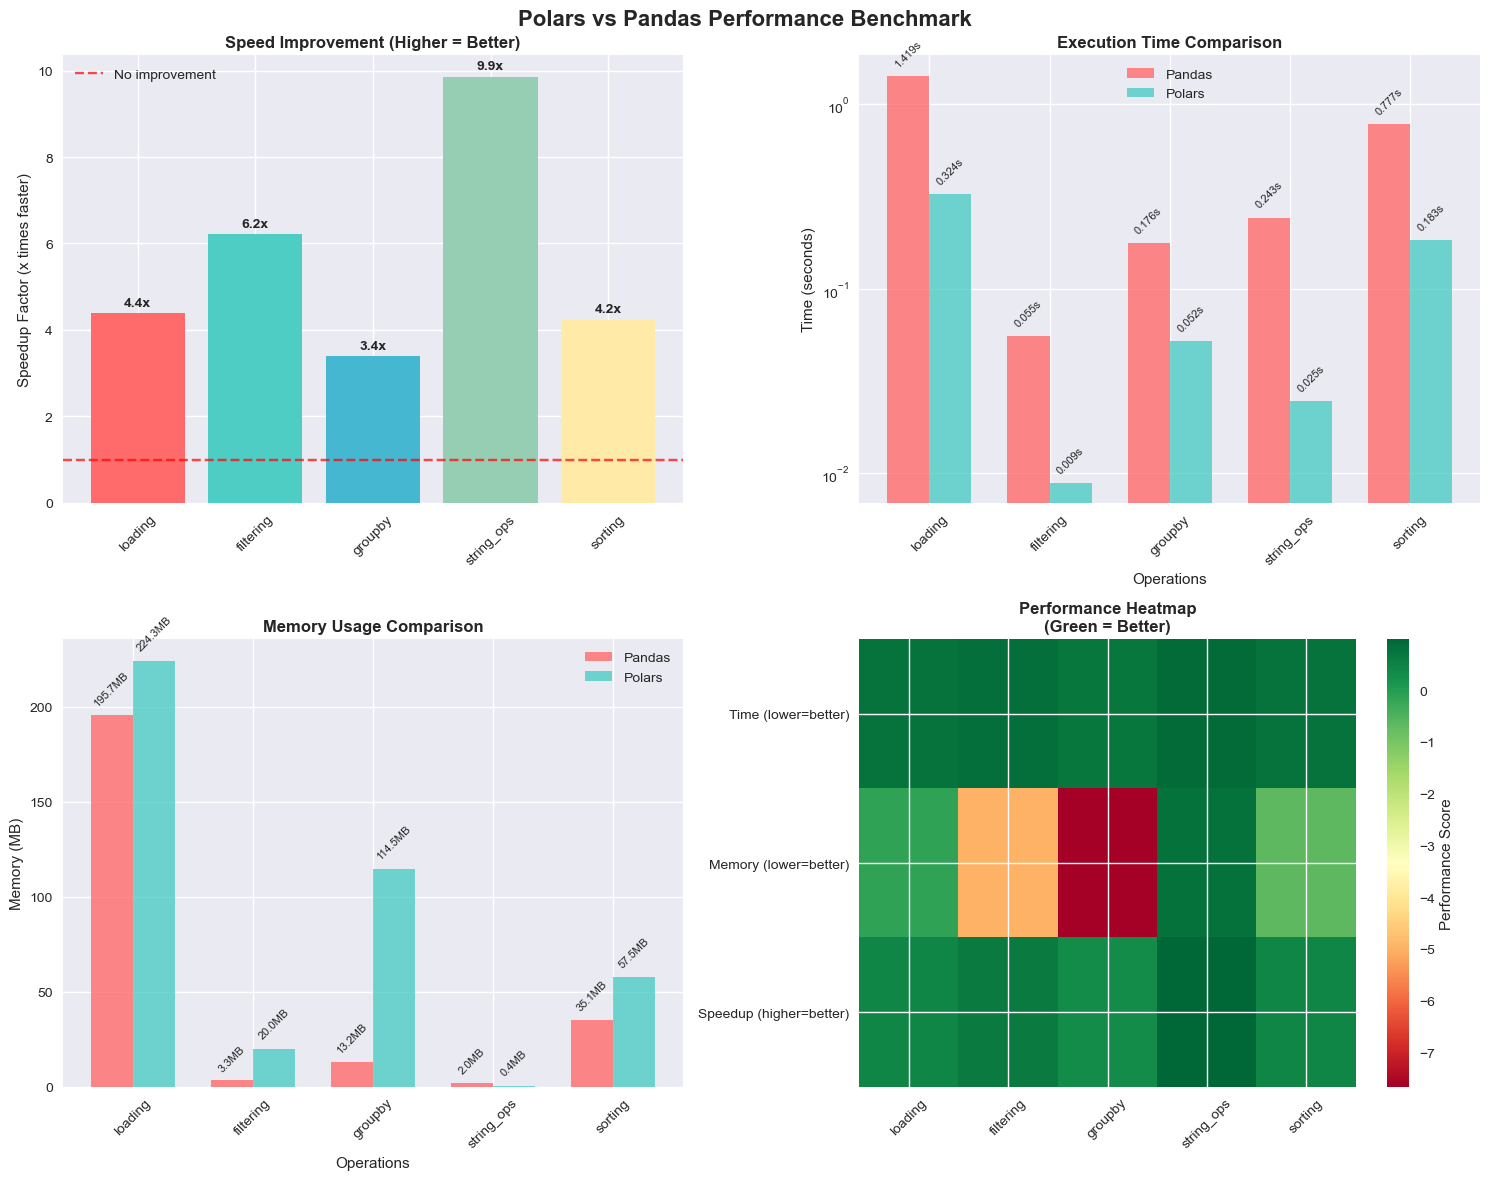


PERFORMANCE SUMMARY
Average speedup: 5.62x
Maximum speedup: 9.86x (string_ops)
Overall time - Pandas: 2.669s
Overall time - Polars: 0.592s
Overall speedup: 4.51x

Cleaned up large_dataset.csv

DETAILED RESULTS

LOADING:
  Pandas time: 1.4189s
  Polars time: 0.3235s
  Speedup: 4.39x
  Memory - Pandas: 195.68MB
  Memory - Polars: 224.33MB

FILTERING:
  Pandas time: 0.0555s
  Polars time: 0.0089s
  Speedup: 6.22x
  Memory - Pandas: 3.33MB
  Memory - Polars: 19.96MB

GROUPBY:
  Pandas time: 0.1760s
  Polars time: 0.0518s
  Speedup: 3.40x
  Memory - Pandas: 13.21MB
  Memory - Polars: 114.46MB

STRING_OPS:
  Pandas time: 0.2425s
  Polars time: 0.0246s
  Speedup: 9.86x
  Memory - Pandas: 1.96MB
  Memory - Polars: 0.38MB

SORTING:
  Pandas time: 0.7765s
  Polars time: 0.1832s
  Speedup: 4.24x
  Memory - Pandas: 35.13MB
  Memory - Polars: 57.49MB


In [13]:
# Run benchmark with 1M rows (adjust as needed)
results = run_complete_benchmark(num_rows=1_000_000)

# Print detailed results
print("\n" + "=" * 50)
print("DETAILED RESULTS")
print("=" * 50)

for operation, metrics in results.items():
    print(f"\n{operation.upper()}:")
    print(f"  Pandas time: {metrics['pandas_time']:.4f}s")
    print(f"  Polars time: {metrics['polars_time']:.4f}s")
    print(f"  Speedup: {metrics['speedup']:.2f}x")
    print(f"  Memory - Pandas: {metrics['pandas_memory']:.2f}MB")
    print(f"  Memory - Polars: {metrics['polars_memory']:.2f}MB")